In [44]:
#Standard

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error as MSE

#Keras
import sysidentpy
from torch import nn

#others
from tqdm.notebook import tqdm
import itertools

In [2]:
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.model_structure_selection import AOLS

from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import compute_residues_autocorrelation, compute_cross_correlation

from sklearn.metrics import r2_score,max_error, mean_absolute_error, mean_squared_error

In [3]:
from sysidentpy.neural_network import NARXNN
print(sysidentpy.__version__)

0.2.0


In [4]:
def inputs_selection(key, target = 'Pressure'):
     
    if target == 'Pressure':
    
        inputs_dict = {
            1:'AVG_DOWNHOLE_PRESSURE',
            2:'AVG_DOWNHOLE_TEMPERATURE',
            3:'BORE_OIL_VOL', #paper used wellhead pressure
            4:'BORE_GAS_VOL',
            5:'BORE_WAT_VOL',
            6:'AVG_CHOKE_SIZE_P',
            7:'ON_STREAM_HRS'
        }
        
    else:
        
        inputs_dict = {
            1:'CUMALATIVE_TIME',
            2:'AVG_DOWNHOLE_TEMPERATURE',
            3:'AVG_DOWNHOLE_PRESSURE', #paper used wellhead pressure
            4:'AVG_CHOKE_SIZE_P',
            5:'AVG_RS',
            6:'AVG_DP_TUBING',
            7:'DP_CHOKE_SIZE',
            8:'BORE_OIL_VOL',
            9:'BORE_GAS_VOL',
            10:'BORE_WAT_VOL'}

    inputs = []
    
    for i in key:
        inputs.append(inputs_dict[i])    
    return inputs

In [5]:
def create_train_test(data, columns, test_size = 0.2):

    train_index = int(data.shape[0]*(1-test_size))
    train_data = df.iloc[:train_index,:]
    test_data = df.iloc[train_index:,:]

    print('TARGET SELECTED = ', inputs_selection([1]))
    
    print('FEATURES SELECTED = ', inputs_selection(columns))
    
    train_X, test_X = train_data.loc[:,inputs_selection(columns)], test_data.loc[:,inputs_selection(columns)]
    train_y, test_y = train_data.loc[:,inputs_selection([1])], test_data.loc[:,inputs_selection([1])]
    
    return np.array(train_X), np.array(test_X), np.array(train_y), np.array(test_y)

In [6]:
def model_train_results(model, train_X, train_y, test_X, test_y):
    
    model.fit(X=train_X, y=train_y)
    
    yhat = model.predict(X=test_X, y=test_y)

    rrse = root_relative_squared_error(test_y, yhat)
    print('RRSE: ',rrse)
    print('R2: ',round(r2_score(test_y, yhat),5))
    
    plot_results(y=test_y, yhat = yhat)
    
    ee = compute_residues_autocorrelation(test_y, yhat)
    plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$")
    x1e = compute_cross_correlation(test_y, yhat, test_X)
    plot_residues_correlation(data=x1e, title="Residues", ylabel="$x_1e$")
    
    return model
    
'''
results_ = pd.DataFrame(
results(
    model.final_model, model.theta, model.err,
    model.n_terms, err_precision=8, dtype='sci'
    ),
columns=['Regressors', 'Parameters', 'ERR'])
print(results_)
'''

"\nresults_ = pd.DataFrame(\nresults(\n    model.final_model, model.theta, model.err,\n    model.n_terms, err_precision=8, dtype='sci'\n    ),\ncolumns=['Regressors', 'Parameters', 'ERR'])\nprint(results_)\n"

In [7]:
#df = pd.read_csv('Volve_NO15-9-F-14H.csv', sep =';', decimal = ',' )

df = pd.read_csv('Volve_production_data.csv', sep =';', decimal = ',' )

#df['AVG_RS'] = pd.to_numeric(df['RS'],errors = 'coerce')
columns_df = list(df)

filtro = df.AVG_DOWNHOLE_PRESSURE == 0
df = df.loc[df.AVG_DOWNHOLE_PRESSURE > 0]

CUMALATIVE_TIME = np.arange(1,df.shape[0]+1)
df.insert(1,'CUMALATIVE_TIME', CUMALATIVE_TIME)

#df.AVG_CHOKE_SIZE_P = df.AVG_CHOKE_SIZE_P.fillna(0)
#display(df.isnull().sum())

filtro = df.WELL_BORE_CODE == 'NO 15/9-F-1 C'
df = df.loc[filtro]

data = pd.DataFrame()
columns = ['AVG_DOWNHOLE_PRESSURE','AVG_DOWNHOLE_TEMPERATURE','BORE_OIL_VOL', 'BORE_GAS_VOL', 'BORE_WAT_VOL', 'AVG_CHOKE_SIZE_P','ON_STREAM_HRS']
for element in columns:
    data[element] = df[element].astype(float)
    
display(data)

df = data

08-03 21:19:08 - INFO - NumExpr defaulting to 6 threads.


,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,AVG_CHOKE_SIZE_P,ON_STREAM_HRS
4,310.376,96.876,0.0,0.0,0.0,1.21599,0.0
5,303.501,96.923,0.0,0.0,0.0,3.08702,0.0
6,303.535,96.959,0.0,0.0,0.0,1.96237,0.0
7,303.782,96.969,0.0,0.0,0.0,0.00000,0.0
8,303.858,97.021,0.0,0.0,0.0,31.14186,0.0
...,...,...,...,...,...,...,...
740,266.148,101.170,0.0,0.0,0.0,0.00000,0.0
741,270.268,101.198,0.0,0.0,0.0,0.00000,0.0
742,276.869,101.231,0.0,0.0,0.0,0.00000,0.0
743,282.105,101.178,0.0,0.0,0.0,0.26519,0.0


#####################################################################
FEATURES SELECTED =  ['AVG_CHOKE_SIZE_P']
#####################################################################


  0%|          | 0/2 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     5
RMSE:  0.3651947010350444
R2:  0.90662
#####################################################################
 Order Selected:     15
RMSE:  0.29755404649685674
R2:  0.92244


,Order,RMSE,R2,Best
0,5,0.365195,0.906619,False
1,15,0.297554,0.922437,True


0.9224373274334071 <sysidentpy.model_structure_selection.forward_regression_orthogonal_least_squares.FROLS object at 0x000001AD06975A30> 15
   Regressors   Parameters             ERR
0      y(k-1)   9.9310E-01  9.99464631E-01
1      y(k-2)  -1.3133E-01  1.00881450E-04
2    x1(k-15)   3.9789E-02  3.20404051E-05
3     x1(k-1)  -2.1128E-01  9.38243140E-06
4           1   3.7921E+01  3.59507354E-05
5     x1(k-2)   1.3972E-01  7.87779217E-06
6     x1(k-3)  -8.5086E-02  9.61915689E-06
7     y(k-10)   8.4709E-02  2.14789071E-06
8     x1(k-6)  -4.6074E-02  2.14433761E-06
9      y(k-6)  -7.4793E-02  9.15762910E-07
10    y(k-15)   1.1222E-01  5.43135533E-07
11    y(k-14)  -1.2214E-01  2.65058211E-06
12   x1(k-14)  -2.1932E-02  5.92700482E-07
13     y(k-7)   5.1450E-02  2.80096759E-07
14     y(k-9)  -4.5015E-02  4.37187947E-07


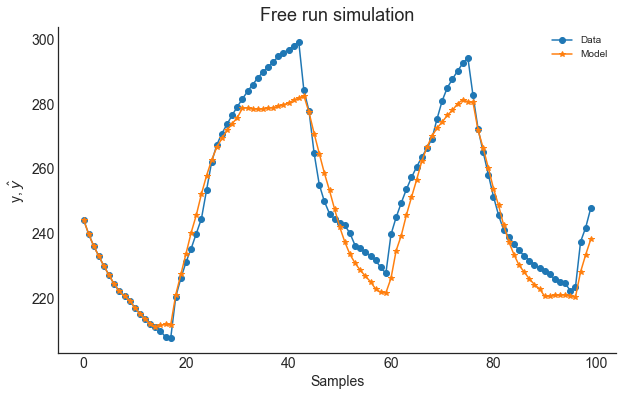

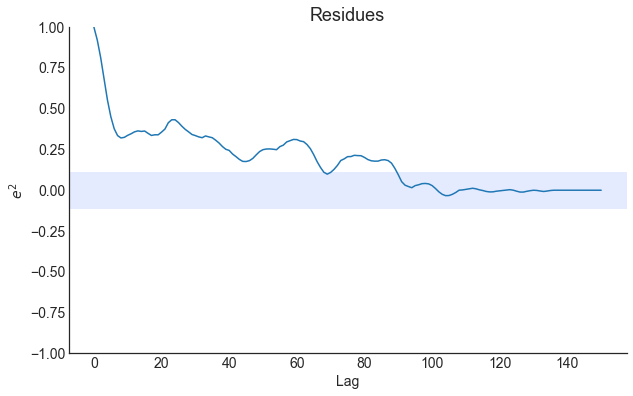

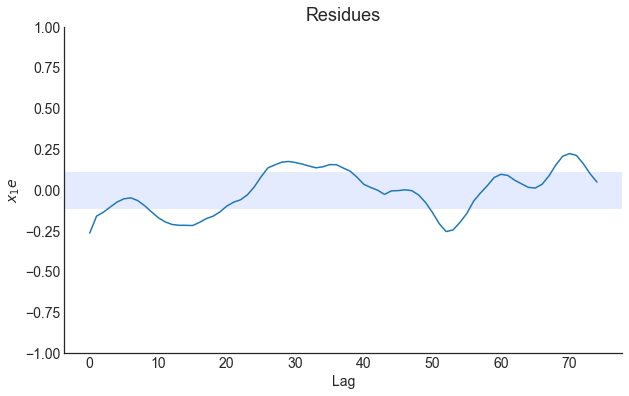

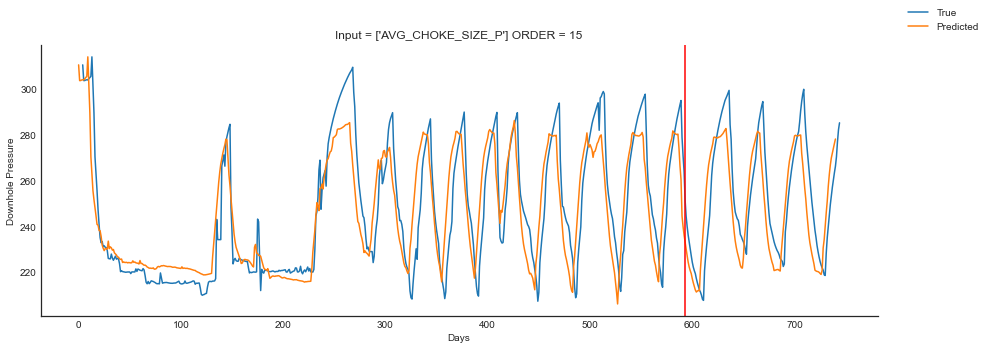

In [8]:
test_size = 0.2
train_index = int(df.shape[0]*(1-test_size))+1

n_order = [5,15]

# Teste apenas do 6:'AVG_CHOKE_SIZE_P'

feature = 6
    
r2_best = 0
history = []
results_ = pd.DataFrame()

X_inputs = inputs_selection([feature])
#best_columns = ['AVG_DOWNHOLE_TEMPERATURE','AVG_CHOKE_SIZE_P','ON_STREAM_HRS']

train_X, test_X = np.array(df.loc[:train_index,X_inputs]) , np.array(df.loc[train_index+1:,X_inputs])
train_y, test_y = np.array(df.loc[:train_index,'AVG_DOWNHOLE_PRESSURE']).reshape(-1,1) , np.array(df.loc[train_index+1:,'AVG_DOWNHOLE_PRESSURE']).reshape(-1,1)
print('#####################################################################')
print('FEATURES SELECTED = ', inputs_selection([feature]))
print('#####################################################################')

for order in tqdm(n_order):

    print('#####################################################################')
    print(' Order Selected:    ',order)                


    basis_function = Polynomial(degree=1)

    lag = list(range(1,order+1))
    
    model = FROLS(
        order_selection=True,
        n_terms=order,
        extended_least_squares=False,
        ylag=order, xlag=order,
        info_criteria='bic',
        estimator='least_squares',
        basis_function=basis_function
    )

    model.fit(X = train_X, y = train_y)

    yhat = model.predict(X=test_X, y=test_y)

    try:
        r2 = r2_score(test_y, yhat)
        rrse = root_relative_squared_error(test_y, yhat)
    except:
        print('MODEL FAILED')
        r2 = 0
        rrse = 0
        pass

    print('RMSE: ',rrse)
    print('R2: ',round(r2,5))


    history.append([order,rrse,r2])

    if r2 > r2_best:      
        r2_best = r2
        best_model = model
        best_order = order

History = pd.DataFrame(history, columns = ['Order','RMSE','R2'])
History['Best'] = (History['R2'] == r2_best)

display(History)

print(r2_best,best_model,best_order)

yhat = best_model.predict(X=test_X, y=test_y)


results_ = pd.DataFrame(
    results(
        model.final_model, best_model.theta, best_model.err,
        best_model.n_terms, err_precision=8, dtype='sci'),
    columns=['Regressors', 'Parameters', 'ERR'])
print(results_)

plot_results(y=test_y, yhat = yhat)

ee = compute_residues_autocorrelation(test_y, yhat)
plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$")
x1e = compute_cross_correlation(test_y, yhat, test_X[:, 0])
plot_residues_correlation(data=x1e, title="Residues", ylabel="$x_1e$")

results_sysid = []
results_sysid = np.concatenate((best_model.predict(X=train_X, y=train_y), yhat), axis=0)

fig,ax1 = plt.subplots(figsize=(15, 5))
ax1.plot(df.loc[:, 'AVG_DOWNHOLE_PRESSURE'], label = 'True')
ax1.plot(results_sysid, label = 'Predicted')
ax1.axvline(x=train_index,color = 'r')
ax1.set_title(f'Input = {inputs_selection([feature])} ORDER = {best_order}',)
ax1.set_ylabel('Downhole Pressure')
ax1.set_xlabel('Days')

fig.legend( loc = 'upper right')
plt.show()


### Improviment try

In [74]:
test_X_scaled.reshape(-1, 1)

array([[6.47886276e-01],
       [6.47402591e-01],
       [6.47333707e-01],
       [6.72448025e-01],
       [7.00737637e-01],
       [5.91862717e-01],
       [5.91921562e-01],
       [5.92622686e-01],
       [5.92466121e-01],
       [5.95270935e-01],
       [6.00813282e-01],
       [6.08708157e-01],
       [6.08021771e-01],
       [6.06656476e-01],
       [6.06907022e-01],
       [6.15173978e-01],
       [6.30420451e-01],
       [1.49405305e-01],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],


NNetwork(
  (INPUT): Linear(in_features=8, out_features=10, bias=True)
  (HIDDEN1): Linear(in_features=10, out_features=10, bias=True)
  (HIDDEN2): Linear(in_features=10, out_features=10, bias=True)
  (OUTPUT): Linear(in_features=10, out_features=1, bias=True)
  (ActFunction): Tanh()
)

MSE:  5.553453801581308


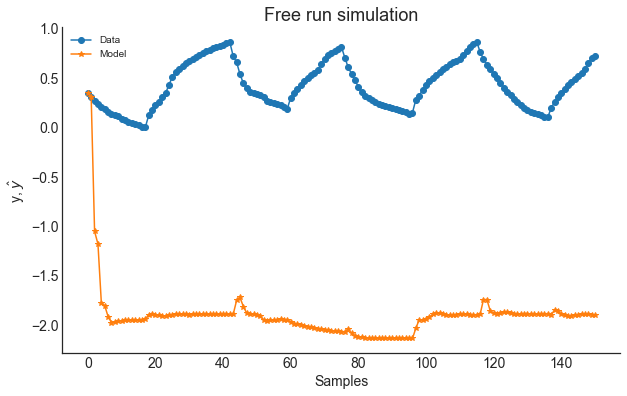

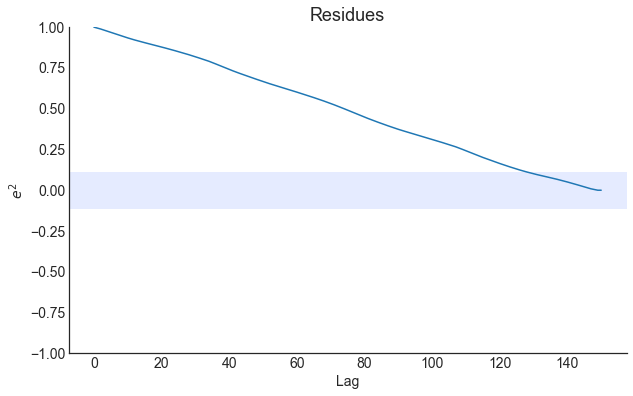

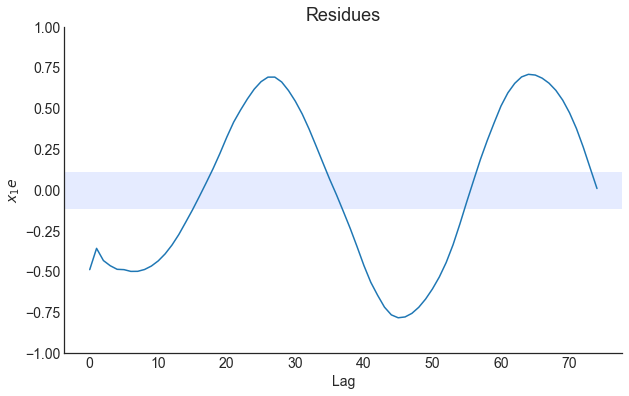

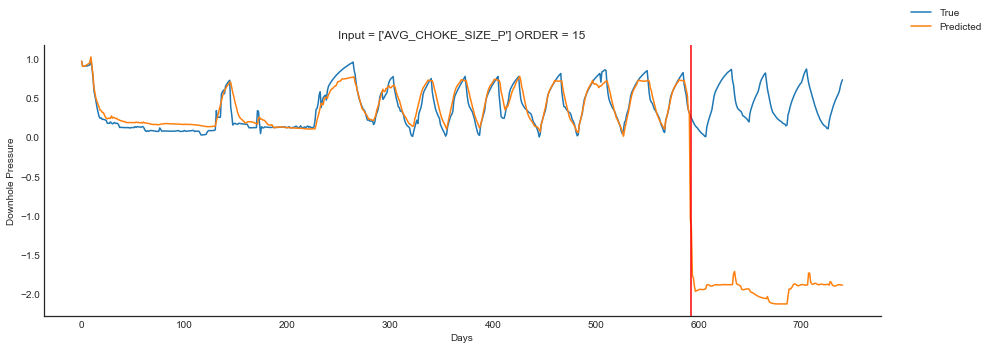

In [77]:
class NNetwork(nn.Module):
    def __init__(self, input_size = 8, hidden_layers=10, f_activation = nn.Tanh()):
        super().__init__()
        self.INPUT = nn.Linear(input_size, hidden_layers)
        self.HIDDEN1 = nn.Linear(hidden_layers, hidden_layers)
        self.HIDDEN2 = nn.Linear(hidden_layers, hidden_layers)
        self.OUTPUT = nn.Linear(hidden_layers, 1)
        self.ActFunction = f_activation

    def forward(self, xb):
        z = self.INPUT(xb)
        z = self.ActFunction(z)
        z = self.HIDDEN1(z)
        z = self.ActFunction(z)
        z = self.HIDDEN2(z)
        z = self.ActFunction(z)
        z = self.OUTPUT(z)
        return z

    
display(NNetwork())    

basis_function = Polynomial(degree=1)
    
narx_net = NARXNN(
    net=NNetwork(),
    ylag=4,
    xlag=4,
    basis_function=basis_function,
    model_type="NARMAX",
    loss_func='mse_loss',
    optimizer='Adam',
    epochs=1000,
    verbose=False,
    optim_params={'betas': (0.9, 0.999), 'eps': 1e-05} # optional parameters of the optimizer
)

yhat_train = best_model.predict(X=train_X, y=train_y)
error_train = abs(train_y - yhat_train) # output train
error_test = abs(test_y - yhat)

scaler = preprocessing.MinMaxScaler()

scaler.fit(np.concatenate((error_train, error_test), axis=0))
error_train_scaled = scaler.transform(error_train)
error_test_scaled = scaler.transform(error_test)

scaler.fit(np.concatenate((train_X, test_X), axis=0))
train_X_scaled = scaler.transform(train_X)
test_X_scaled = scaler.transform(test_X)

scaler.fit(np.concatenate((train_y, test_y), axis=0))
train_y_scaled = scaler.transform(train_y)
test_y_scaled = scaler.transform(test_y)
yhat_train_scaled = scaler.transform(yhat_train)
yhat_scaled = scaler.transform(yhat)

narx_net.fit(X=train_X_scaled.reshape(-1, 1), y=error_train_scaled.reshape(-1, 1))
yhat_neural = narx_net.predict(X=test_X_scaled, y=error_test_scaled)

yhat_final = yhat_neural + yhat_scaled

print("MSE: ", mean_squared_error(test_y_scaled, yhat_final))
plot_results(y=test_y_scaled, yhat=yhat_final, n=1000)
ee = compute_residues_autocorrelation(test_y_scaled, yhat_final)
plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$")
x1e = compute_cross_correlation(test_y_scaled, yhat_final, test_X_scaled)
plot_residues_correlation(data=x1e, title="Residues", ylabel="$x_1e$")

results_sysid = []

Yhat_train_final = yhat_train_scaled + abs(narx_net.predict(X=train_X_scaled, y=error_train_scaled))

results_sysid = np.concatenate((Yhat_train_final, yhat_final), axis=0)
data_scaled = np.concatenate((train_y_scaled, test_y_scaled), axis=0)

fig,ax1 = plt.subplots(figsize=(15, 5))
ax1.plot(data_scaled, label = 'True')
ax1.plot(results_sysid, label = 'Predicted')
ax1.axvline(x=train_index,color = 'r')
ax1.set_title(f'Input = {inputs_selection([feature])} ORDER = {best_order}',)
ax1.set_ylabel('Downhole Pressure')
ax1.set_xlabel('Days')

fig.legend( loc = 'upper right')
plt.show()

In [20]:
help(narx_net.predict)

Help on method predict in module sysidentpy.neural_network.narx_nn:

predict(*, X=None, y=None, steps_ahead=None, forecast_horizon=None) method of sysidentpy.neural_network.narx_nn.NARXNN instance
    Return the predicted given an input and initial values.
    
    The predict function allows a friendly usage by the user.
    Given a trained model, predict values given
    a new set of data.
    
    This method accept y values mainly for prediction n-steps ahead
    (to be implemented in the future).
    
    Currently we only support infinity-steps-ahead prediction,
    but run 1-step-ahead prediction manually is straightforward.
    
    Parameters
    ----------
    X : ndarray of floats
        The input data to be used in the prediction process.
    y : ndarray of floats
        The output data to be used in the prediction process.
    
    Returns
    -------
    yhat : ndarray of floats
        The predicted values of the model.



## NARX

In [ ]:
test_size = 0.2
train_index = int(df.shape[0]*(1-test_size))+1

n_order = [5,15]

# Teste apenas do 6:'AVG_CHOKE_SIZE_P'
for feature in np.arange(6,7):
    
    r2_best = 0
    history = []
    results_ = pd.DataFrame()

    X_inputs = inputs_selection([feature])
    #best_columns = ['AVG_DOWNHOLE_TEMPERATURE','AVG_CHOKE_SIZE_P','ON_STREAM_HRS']

    train_X, test_X = np.array(df.loc[:train_index,X_inputs]) , np.array(df.loc[train_index+1:,X_inputs])
    train_y, test_y = np.array(df.loc[:train_index,'AVG_DOWNHOLE_PRESSURE']).reshape(-1,1) , np.array(df.loc[train_index+1:,'AVG_DOWNHOLE_PRESSURE']).reshape(-1,1)
    print('#####################################################################')
    print('FEATURES SELECTED = ', inputs_selection([feature]))
    print('#####################################################################')
    
    for order in tqdm(n_order):
    
        print('#####################################################################')
        print(' Order Selected:    ',order)                


        basis_function = Polynomial(degree=2)

        lag = list(range(1,order+1))
        model = FROLS(
            order_selection=True,
            n_terms=order,
            extended_least_squares=False,
            ylag=order, xlag=order,
            info_criteria='bic',
            estimator='least_squares',
            basis_function=basis_function
        )

        model.fit(X = train_X, y = train_y)

        yhat = model.predict(X=test_X, y=test_y)
        
        try:
            r2 = r2_score(test_y, yhat)
            rrse = root_relative_squared_error(test_y, yhat)
        except:
            print('MODEL FAILED')
            r2 = 0
            rrse = 0
            pass
        
        print('RMSE: ',rrse)
        print('R2: ',round(r2,5))


        history.append([order,rrse,r2])

        if r2 > r2_best:      
            r2_best = r2
            best_model = model
            best_order = order

    History = pd.DataFrame(history, columns = ['Order','RMSE','R2'])
    History['Best'] = (History['R2'] == r2_best)

    display(History)

    print(r2_best,best_model,best_order)

    yhat = best_model.predict(X=test_X, y=test_y)
    
    
    results_ = pd.DataFrame(
        results(
            model.final_model, best_model.theta, best_model.err,
            best_model.n_terms, err_precision=8, dtype='sci'),
        columns=['Regressors', 'Parameters', 'ERR'])
    print(results_)
    
    plot_results(y=test_y, yhat = yhat)

    ee = compute_residues_autocorrelation(test_y, yhat)
    plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$")
    x1e = compute_cross_correlation(test_y, yhat, test_X[:, 0])
    plot_residues_correlation(data=x1e, title="Residues", ylabel="$x_1e$")

    results_sysid = []
    results_sysid = np.concatenate((best_model.predict(X=train_X, y=train_y), yhat), axis=0)

    fig,ax1 = plt.subplots(figsize=(15, 5))
    ax1.plot(df.loc[:, 'AVG_DOWNHOLE_PRESSURE'], label = 'True')
    ax1.plot(results_sysid, label = 'Predicted')
    ax1.axvline(x=train_index,color = 'r')
    ax1.set_title(f'Input = {inputs_selection([feature])} ORDER = {best_order}',)
    ax1.set_ylabel('Downhole Pressure')
    ax1.set_xlabel('Days')

    fig.legend( loc = 'upper right')
    plt.show()
